<a href="https://colab.research.google.com/github/pranay8297/deep-learning-projects/blob/master/super_ress_new_still_pending.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
!pip install "torch==1.4" "torchvision==0.5.0"

In [35]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *

from torchvision.models import vgg16_bn

In [36]:
path = untar_data(URLs.PETS)
path.ls()

[PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/med_q'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/low_q')]

In [37]:
path_hr = path/'images'
path_lr = path/'low_q'
path_mr = path/'med_q'

paths = [(path_lr, 96), (path_mr, 256)]

for i, j in paths:
  i.mkdir(exist_ok=True)

path.ls()

[PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/med_q'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/low_q')]

In [38]:
il = ImageList.from_folder(path_hr)
test = il.items[0]

In [39]:
def resize_img(fn, _, path, size): 
  dest = path/fn.relative_to(path_hr)
  img = PIL.Image.open(fn)
  targ_sz = resize_to(img, size, use_min= True)
  img = img.resize(targ_sz,
  resample = PIL.Image.BILINEAR).convert('RGB')
  img.save(dest, quality = 60)

In [40]:
for i in paths:
  parallel(partial(resize_img, path = i[0], size = i[1]), il.items)

In [41]:
test.name;
path_hr

PosixPath('/root/.fastai/data/oxford-iiit-pet/images')

In [42]:
src = ImageImageList.from_folder(path_lr).split_by_rand_pct().label_from_func(lambda x: path_hr/x.name)

In [43]:
size, bs = 128, 32

def get_data(bs, size):
  data = src.transform(get_transforms(max_zoom = 2.), tfm_y = True, size = size).databunch(bs = bs).normalize(imagenet_stats)
  data.c = 3
  return data

data = get_data(bs, size)

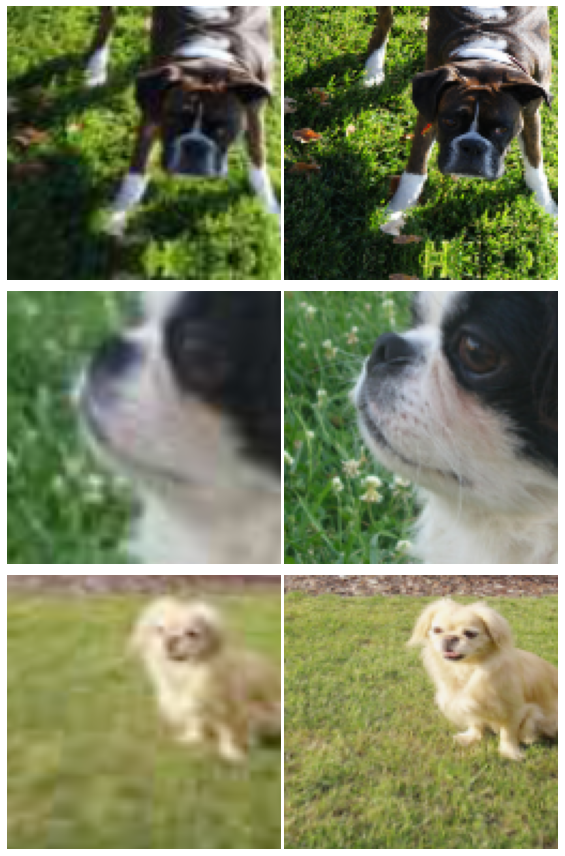

In [44]:
data.show_batch(rows = 3)

In [45]:
arch = models.resnet34

In [46]:
vgg = vgg16_bn()

In [47]:
x = data.valid_ds[0][1]
x.data

tensor([[[0.3992, 0.4029, 0.4324,  ..., 0.3565, 0.3582, 0.3536],
         [0.4215, 0.4458, 0.4839,  ..., 0.3551, 0.3523, 0.3626],
         [0.4728, 0.4923, 0.4969,  ..., 0.3503, 0.3473, 0.3542],
         ...,
         [0.5649, 0.5654, 0.5732,  ..., 0.1792, 0.1773, 0.1767],
         [0.5753, 0.5778, 0.5812,  ..., 0.1864, 0.1831, 0.1838],
         [0.5887, 0.5888, 0.5819,  ..., 0.1894, 0.1862, 0.1873]],

        [[0.3152, 0.3165, 0.3227,  ..., 0.2327, 0.2327, 0.2297],
         [0.3304, 0.3531, 0.3719,  ..., 0.2296, 0.2247, 0.2286],
         [0.3699, 0.3862, 0.3865,  ..., 0.2248, 0.2218, 0.2211],
         ...,
         [0.4238, 0.4260, 0.4336,  ..., 0.0856, 0.0834, 0.0857],
         [0.4320, 0.4387, 0.4504,  ..., 0.0934, 0.0890, 0.0897],
         [0.4453, 0.4539, 0.4600,  ..., 0.0981, 0.0920, 0.0931]],

        [[0.2494, 0.2467, 0.2732,  ..., 0.1417, 0.1425, 0.1387],
         [0.2683, 0.2914, 0.3119,  ..., 0.1397, 0.1352, 0.1412],
         [0.3150, 0.3336, 0.3246,  ..., 0.1386, 0.1316, 0.

In [49]:
y = vgg.features(x.data[None])
y.shape

torch.Size([1, 512, 4, 4])

In [50]:
z = vgg(x.data[None])
z.shape
z[0][:10]

tensor([ 0.1333, -1.2694,  1.0944, -1.0384, -0.2099, -1.2767, -0.1122,  0.4164,
         0.0422,  1.0895], grad_fn=<SliceBackward>)

In [ ]:
layers = vgg.features.eval()
type(layers)
children(layers), len(children(layers))

In [64]:
features = vgg.features.cuda().eval()
layer_ids = []
layers = []
for l_index, l in enumerate(children(features)):
  if isinstance(l, nn.MaxPool2d):
    layer_ids.append(l_index - 1)
    layers.append(l)
print(layer_ids)

[5, 12, 22, 32, 42]


In [86]:
layers = [children(features)[i-1] for i in layer_ids]
layers
new_x = layers[0]

for i in new_x.parameters():
  print(type(i))
  p = i

In [91]:
new_x

BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [93]:
!pip install ipdb 
from ipdb import set_trace as st

  Created wheel for ipdb: filename=ipdb-0.13.3-cp36-none-any.whl size=10848 sha256=0cea6de7312072074dda04afffca3c6ef4ad5f3ac06cb1717c5df535875a1082
  Stored in directory: /root/.cache/pip/wheels/75/00/30/4169bcc3643f0cf946dcf37af1b71364b390c4df91da02b03c
Successfully built ipdb


In [68]:
base_loss = F.l1_loss

In [113]:
class FeatureLoss(nn.Module):
  def __init__(self, base_model, base_loss, layer_ids, layer_wgts):
    super().__init__()

    self.m_feat = base_model
    self.loss_fn = base_loss
    self.wgts = layer_wgts
    self.layer_ids = layer_ids

    self.loss_features = [base_model[i] for i in self.layer_ids]
    self.hook_loss = hook_outputs(self.loss_features, detach= False)

    self.metric_names = ['Pixel_loss'] + [f'layer_loss_{i}' for i in self.layer_ids]

  def make_features(self, x, clone = False):
    self.m_feat(x)
    return [(o.clone() if clone else o) for o in self.hook_loss.stored]
  
  def forward(self, input, target):
    targ_feat = self.make_features(target, True)
    in_feat = self.make_features(input)

    pixel_loss = self.loss_fn(input, target)
    feature_losses = [self.loss_fn(inp, targ)*w for inp, targ, w in zip(in_feat, targ_feat, self.wgts)]

    self.losses = [pixel_loss, *feature_losses]
    self.metrics = dict(zip(self.metric_names, self.losses))

    return sum(self.losses)
  
  def __del__(self):
    self.hook_loss.remove()

In [114]:
loss_fn = FeatureLoss(vgg.features.cuda().eval(), base_loss, layer_ids, [2, 4, 6, 12, 5])

In [116]:
x, y = data.valid_ds[0]
x, y = x.data[None].cuda(), y.data[None].cuda()
loss = loss_fn(x,y)

In [121]:
learn = unet_learner(data, arch=arch, loss_func = loss_fn, callback_fns = LossMetrics, blur= True, norm_type = NormType.Weight, wd = 1e-3)

In [122]:
learn.lr_find()

epoch,train_loss,valid_loss,Pixel_loss,layer_loss_5,layer_loss_12,layer_loss_22,layer_loss_32,layer_loss_42,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


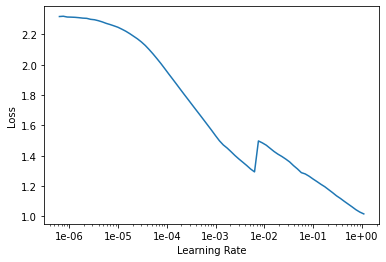

In [123]:
learn.recorder.plot()

In [124]:
learn.fit_one_cycle(10, slice(3e-04, 1e-03))

epoch,train_loss,valid_loss,Pixel_loss,layer_loss_5,layer_loss_12,layer_loss_22,layer_loss_32,layer_loss_42,time
0,0.258349,0.197034,0.054640,0.018584,0.029273,0.030325,0.046148,0.018066,01:20
1,0.176272,0.182139,0.048604,0.016039,0.026497,0.028657,0.044672,0.017670,01:19
2,0.148795,0.142234,0.035185,0.012800,0.021306,0.022761,0.035860,0.014321,01:19
3,0.136721,0.129572,0.031618,0.011249,0.019370,0.020900,0.033147,0.013289,01:19
4,0.129301,0.125582,0.030648,0.010952,0.018732,0.020228,0.032120,0.012902,01:19
5,0.124484,0.121937,0.029709,0.010574,0.018169,0.019646,0.031252,0.012588,01:19
6,0.121787,0.118215,0.028468,0.010193,0.017657,0.019110,0.030453,0.012334,01:19
7,0.119704,0.116901,0.028216,0.010109,0.017452,0.018875,0.030072,0.012177,01:19
8,0.119432,0.116060,0.028092,0.010052,0.017286,0.018716,0.029830,0.012083,01:19
9,0.118249,0.115804,0.027996,0.010023,0.017255,0.018684,0.029778,0.012067,01:19


In [127]:
def train_model(save_name, lrs, pct_start = 0.9, epocs = 10):
  learn.fit_one_cycle(epocs, lrs, pct_start = pct_start)
  learn.save(save_name)
  learn.show_results(rows = 2, imgsize = 5)

epoch,train_loss,valid_loss,Pixel_loss,layer_loss_5,layer_loss_12,layer_loss_22,layer_loss_32,layer_loss_42,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


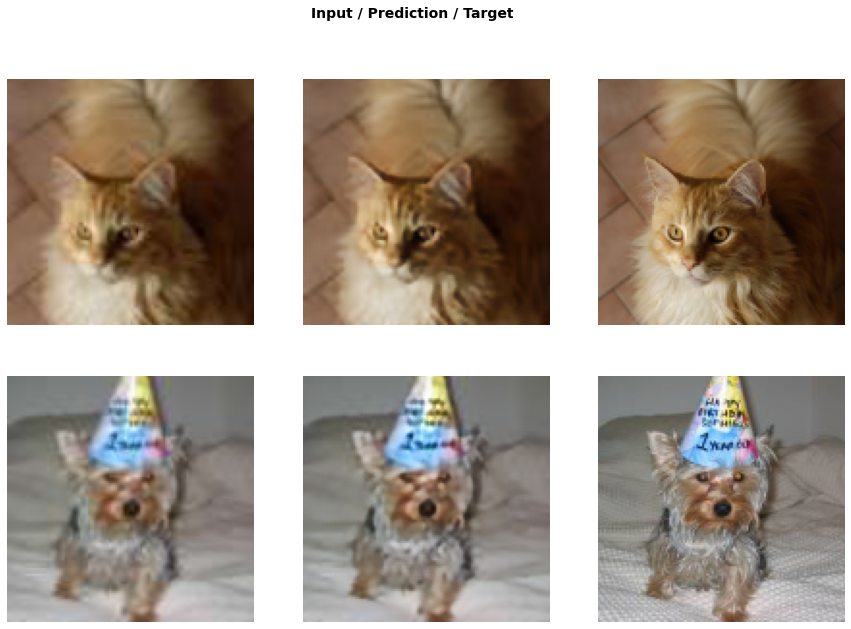

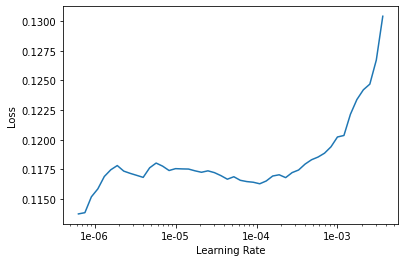

In [125]:
learn.show_results(rows = 2, imgsize = 5)
learn.save('stage_1')
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [ ]:
train_model('stage_2', slice(1e-06, 2e-04), epocs = 20)